In [1]:
!pip install neuron

from neuron.units import mV,ms,um # unit definition
from matplotlib import pyplot
import numpy as np
import itertools
from neuron import h, gui, rxd # chemical dynamic
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution
from neuron.units import mV, ms, um  # NEURON-defined units


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 17.1 MB/s eta 0:00:00


In [ ]:
# Loading 3D structure directly from swc file
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")


class LGMD:
    def __init__(self,morphology):
        self.morphology = morphology
        self.load_morphology()
        self.discretize()
    def __str__(self):
        return self.morphology
    def discretize(self):
        for sec in self.all:
            sec.nseg = int(sec.L) +1
            if sec.nseg % 2 == 0:
                sec.nseg += 1
    def load_morphology(self):
        # Create a cell object
        LGMD = h.Import3d_SWC_read()
        LGMD.input(f"{self.morphology}.swc")
        i3d = h.Import3d_GUI(LGMD, False)
        i3d.instantiate(self)
        #self.set_nseg_by_d_lambda(d_lambda=0.1)  # You can adjust d_lambda as needed

# Instantiate the LGMD class
LGMD1 = LGMD ("/Users/samme/Library/CloudStorage/OneDrive-Emory/Lab/LGMD project/LGMD_Data/LGMD_Reconstruction/Output/Fully_Connected_LGMD_sorted")

# Plot the shape of the cell
ps = h.PlotShape(False)
ps.plot(plotly).show()


In [2]:
# Load hoc file directly
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
def load_neuron_model(hoc_file_path):
    """
    Load a neuron model from a hoc file, set up the NEURON environment,
    and allow for flexible naming of the NEURON object.

    """
    # Import NEURON module and load the hoc file
    h.load_file(hoc_file_path)

    # Create a PlotShape object for visualization
    ps = h.PlotShape(False)
    ps.plot(plotly).show()

    neuron_obj = h
    return neuron_obj

hocpath = "/content/LGMD_Complete_Construction.hoc"
LGMD1 = load_neuron_model(hocpath)

In [4]:
# get information for all segments
import itertools

def neuron_info(neuron_obj):
    """
    Prints information about the neuron model loaded in NEURON, such as the
    number of sections, minimum and maximum diameters, and details for each section.

    Parameters:
        neuron_obj: The NEURON object containing the model.
    """
    # Calculate the number of sections
    num_sections = sum(1 for _ in neuron_obj.allsec())
    print(f"Number of sections: {num_sections}")

    # Flatten diameters of all sections into a single list
    all_dims = list(itertools.chain.from_iterable(
        [[sec.diam3d(i) for i in range(sec.n3d())] for sec in neuron_obj.allsec()]
    ))

    print(f"Minimum diameter = {min(all_dims)} um")
    print(f"Maximum diameter = {max(all_dims)} um")

    # Print detailed information for each section
    for sec in neuron_obj.allsec():
        print(f"Section name: {sec.name()}")
        print(f"  Number of segments (nseg): {sec.nseg}")
        print(f"  Number of nodes: {int(sec.n3d())}")
        print(f"  Length (um): {sec.L}")
        print(f"  Diameter (um): {sec.diam}")

neuron_info(LGMD1)  # call


Streaming output truncated to the last 5000 lines.
Section name: FieldB[149]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 3.5186772783135116
  Diameter (um): 2.0
Section name: FieldB[150]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 1.3919140883077923
  Diameter (um): 2.0
Section name: FieldB[151]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 3.160518703192885
  Diameter (um): 1.9999999999999998
Section name: FieldB[152]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 0.49394644821818146
  Diameter (um): 2.0
Section name: FieldB[153]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 3.5404830810115
  Diameter (um): 1.9999999999999998
Section name: FieldB[154]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 1.3822085104277673
  Diameter (um): 2.0
Section name: FieldB[155]
  Number of segments (nseg): 1
  Number of nodes: 2
  Length (um): 6.064015111523657
  Diameter (u

In [ ]:
# Plot diameter of each section at different points wrt to distance from soma
fig = go.Figure()
for sec in LGMD1.allsec():
    # h.RangeVarPlot("rangevar" [, start_segment, stop_segment])
    rvp = h.RangeVarPlot ("diam", LGMD1.soma[0](0), sec(1))
    rvp.plot(fig)

fig.update_layout(
    title="Distance from soma for each segment vs. diameter change",
    xaxis_title="Distance from soma (um)",
    yaxis_title="Diameter (um)"
)


In [5]:
import re

segment_type_counts = {}
segment_type_nodes = {}

# Extract segment type names from all sections and count them
for sec in h.allsec():
    # Extract the segment type name (e.g., 'apic' from 'apic[1]')
    segment_type = re.split(r'\[', sec.name())[0]

    # Increment the count for this segment type
    segment_type_counts[segment_type] = segment_type_counts.get(segment_type, 0) + 1

    # Get the number of nodes (3D points) for this section
    num_nodes = int(sec.n3d())

    # Add the number of nodes to the total for this segment type
    segment_type_nodes[segment_type] = segment_type_nodes.get(segment_type, 0) + num_nodes

unique_segment_types = sorted(segment_type_counts.keys())

# Print the number of unique segment types and their segment and node counts
print(f"Number of unique segment types: {len(unique_segment_types)}")
for segment_type in unique_segment_types:
    num_segments = segment_type_counts[segment_type]
    total_nodes = segment_type_nodes[segment_type]
    print(f"  Segment Type: {segment_type}, Number of Segments: {num_segments}, Total Nodes: {total_nodes}")

# Total nodes after importing
total_nodes_in_tree = sum(segment_type_nodes.values())
print(f"Total number of nodes in this tree: {total_nodes_in_tree/2 +1}")

# soma = soma (1); axon = axon (2); dend = FieldA (3);

Number of unique segment types: 7
  Segment Type: Axon, Number of Segments: 44, Total Nodes: 88
  Segment Type: Cellbody, Number of Segments: 69, Total Nodes: 138
  Segment Type: FieldA, Number of Segments: 1702, Total Nodes: 3404
  Segment Type: FieldB, Number of Segments: 674, Total Nodes: 1348
  Segment Type: FieldC, Number of Segments: 319, Total Nodes: 638
  Segment Type: FieldD, Number of Segments: 87, Total Nodes: 174
  Segment Type: soma, Number of Segments: 1, Total Nodes: 2
Total number of nodes in this tree: 2897.0


In [6]:
# based on Peron, 2007
V_m = -65        # Resting membrane potential in mV
R_m = 5000       # Specific membrane resistivity in Ohm·cm²
C_m = 0.7          # Specific membrane capacitance in µF/cm² (NOT CORRECT, Should be <= 1)
#tau_m = 6.6      # Membrane time constant in ms
R_a = 57         # Axial resistance in Ohm·cm
G_pas = 1 / R_m  # Passive leaky conductance in S/cm²
# Input resistance is resistance at the point of current injection

# Insert passive properties into all sections and current injection
for sec in h.allsec():
    sec.insert('pas')        # Insert passive mechanism
    sec.Ra = R_a             # Axial resistivity (Ohm cm)
    sec.cm = C_m             # Membrane capacitance (uF/cm^2)
    sec.g_pas = G_pas        # Leak conductance (S/cm^2)
    sec.e_pas = V_m          # Leak reversal potential (mV)

def record_segment(inj_site, recor_site, current = -1, duration= 3250, stim_dur = 1500, delay = 250, init_vm=-65, delta_t=0.05):
    """
    Record and plot the membrane potential at a specific segment in the neuron.

    Parameters:
    - inj_site, recor_site (e.g., soma[0](0.5)).
    - duration: Total simulation time in ms
    - init_vm: Initial membrane potential
    """

    # Set simulation parameters
    h.tstop = duration  # Total duration in ms
    h.v_init = init_vm  # Initial V_m (mV)
    h.dt = delta_t      # Time step for simulation (ms)

    # Create current clamp at the specified segment
    stim = h.IClamp(inj_site)
    stim.delay = delay      # Start of stimulus (ms)
    stim.dur = stim_dur  # Duration of stimulus (ms)
    stim.amp = current   # Amplitude of stimulus (nA)

    # Record membrane potential and time
    v_vec = h.Vector()  # V_m vector
    t_vec = h.Vector()  # Time vector
    v_vec.record(recor_site._ref_v)
    t_vec.record(h._ref_t)

    # Initialize and run the simulation
    h.tstop = duration  # Total duration in ms
    h.finitialize(h.v_init)
    h.continuerun(h.tstop)

    return v_vec, t_vec

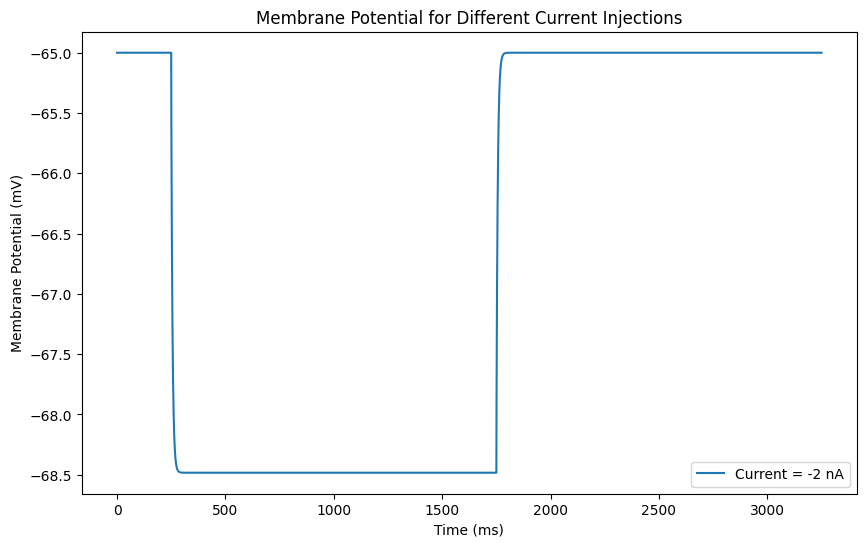

In [18]:
# Run current injection experiment with

current_values = [-2]  # nA

all_voltages = []
all_times = []
inj_site = LGMD1.FieldA[809](0.5) # base of field A
record_site = LGMD1.FieldA[809](0.5)

# Loop through each current value
for current in current_values:

    v_vec, t_vec = record_segment(inj_site, record_site, current=current)

    # Store the recorded voltage and time vectors
    all_voltages.append(np.array(v_vec))
    all_times.append(np.array(t_vec))

# Plot the results on same graph
plt.figure(figsize=(10, 6))
for i, current in enumerate(current_values):
    plt.plot(all_times[i], all_voltages[i], label=f"Current = {current} nA")

plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Membrane Potential for Different Current Injections")
plt.legend()
plt.show()

In [17]:
# Define the fitting function
np.set_printoptions(threshold=100)

def fit_passive_parameters(exp_vol, exp_t, inj_site, recor_site, stim_dur, current, init_vm = -65):
    """
    Fit Ra, cm, and g_pas to match the experimental voltage data.

    Parameters:
    - exp_vol: Array of experimental voltage data
    - exp_t: Array of experimental time point
    - inj_site, recor_site: Injection and recording sites (e.g., soma[0](0.5))
    - current: Current injection amplitude (nA)
    - init_vm: Initial membrane potential (mV)
    """
    delay_t =  np.round (abs (exp_t[0]) * 1000, decimals = 6) # convert to ms
    exp_t =  np.round ((exp_t + abs (exp_t[0])) * 1000, decimals = 6)  # shift to all positive
    current_end_time = delay_t + stim_dur  # End time of current injection
    t_fit_end = current_end_time
    t_fit_start = current_end_time - 1000

    exp_indices = np.where((exp_t >= t_fit_start) & (exp_t <= t_fit_end))[0]
    exp_v = exp_vol[exp_indices]
    exp_t_window = exp_t[exp_indices]

    # Check if the experimental data is sampled at constant intervals
    delta_t_exp = np.diff(exp_t_window)
    if not np.allclose(delta_t_exp, delta_t_exp[0]):
        print("Experimental data is not sampled at constant intervals. Cannot proceed without interpolation.")
        return

    delta_t_sim = np.round(delta_t_exp[0], decimals = 2) # Set simulation time step to match experimental sampling interval
    N_data = len(exp_t_window)  # Number of data points in fitting window
    print (N_data)


    # Objective function to minimize
    def objective_function(params):
        Ra, cm, Rm = params
        print (f"Trying - Ra: {Ra}, cm: {cm}, g_pas: {1/Rm}")
        # Update model
        for sec in h.allsec():
            sec.insert('pas')
            sec.insert('pas')
            sec.e_pas = init_vm  # fixed passive Voltage
            sec.Ra = Ra
            sec.cm = cm
            sec.g_pas = np.round (1/Rm, decimals = 5)

        # Simualtion to record voltage and interpolate to exp data
        sim_t = 1020
        duration = sim_t + delay_t + 10 # padding
        v_vec, t_vec = record_segment(inj_site, recor_site, current=current,
                                      duration=duration, stim_dur = sim_t,
                                      delay = delay_t, init_vm=init_vm, delta_t=delta_t_sim)
        v_vec = np.array(v_vec)
        t_vec = np.array(t_vec)

        # Only fit a 1000ms window during injection
        temp = int((sim_t + delay_t - 1000)/delta_t_sim)
        sim_v = v_vec[temp:N_data + temp]
        print (sim_v)
        print (exp_v)
        mse = np.mean((sim_v - exp_v) ** 2)
        print (f"MSE: {mse}")
        return mse

    # Initial guess and bounds for parameters
    #initial_guess = [60, 0.7, 4500]  # Ra, cm, and R_M
    bounds = [(58,60), (0.8, 1), (4500, 5000)]  # Ra, cm, R_M

    # Optimization function
    result = differential_evolution(objective_function, bounds, maxiter=10)

    Ra_opt, cm_opt, Rm_opt = result.x
    print("Optimized Ra:", Ra_opt)
    print("Optimized cm:", cm_opt)
    print("Optimized Rm:", Rm_opt)

    return Ra_opt, cm_opt, Rm_opt, exp_t, exp_vol


In [7]:
# Import exp data
import pandas as pd
data = pd.read_csv('/content/experimental_data.csv', header=None)
experimental_t = data[0].values        # First column for time
experimental_voltage = data[1].values  # Second column for voltage

# Verify the arrays
print(f"Experimental Time and length ({len(experimental_t)}): {experimental_t}")
print(f"Experimental Voltage and length ({len(experimental_voltage)}): {experimental_voltage}")
inj_site = LGMD1.FieldA[809](0.5) # base of field A
record_site = LGMD1.FieldA[809](0.5)


Experimental Time and length (65237): [-0.24999 -0.24994 -0.24989 ...  2.9999   2.9999   3.     ]
Experimental Voltage and length (65237): [-64.856 -64.849 -64.858 ... -65.035 -65.035 -65.034]


[-64.856 -64.849 -64.858 ... -65.035 -65.035 -65.034] 65000
[-0.25    -0.24995 -0.2499  ...  2.9999   2.99995  3.     ] 65000


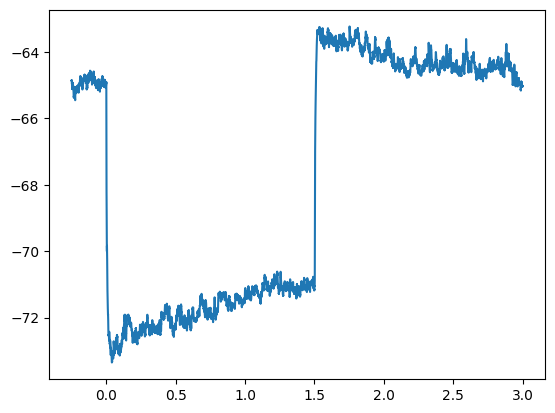

In [8]:
# Force the exp data into the shape of simulation
delay_duration = 0.25  # Delay period before t=0 in seconds
recording_duration = 1.5  # Recording period in seconds
post_recording_duration = 1.5

exp_vol_mod = []
delta_t = 0.05  # in ms
middle_segment_size = int(1.5 / (delta_t / 1000))  # Convert to number of elements: 1.5 sec / 0.00005 sec
exp_vol_mod = experimental_voltage[:5000]
middle_start_idx = np.where(experimental_t >= 0)[0][0]  # Find the index where t >= 0
exp_vol_mod = np.append(exp_vol_mod, experimental_voltage[middle_start_idx:middle_start_idx + middle_segment_size])
exp_vol_mod = np.append(exp_vol_mod, experimental_voltage[-30000:])


delay_steps = int(delay_duration / (delta_t / 1000))  # Convert to number of steps
recording_steps = int(recording_duration / (delta_t / 1000))
post_recording_steps = int(post_recording_duration / (delta_t / 1000))

delay_time = np.linspace(-delay_duration, 0, delay_steps, endpoint=False)  # Time before t=0
recording_time = np.linspace(0, recording_duration, recording_steps, endpoint=False)  # Time during recording
post_recording_time = np.linspace(recording_duration, recording_duration + post_recording_duration, post_recording_steps)

# Combine time segments to form exp_mod_t
exp_t_mod = np.concatenate((delay_time, recording_time, post_recording_time))

print (exp_vol_mod, len(exp_vol_mod))
print (exp_t_mod, len(exp_t_mod))
#plt.plot (exp_vol_mod)
plt.plot(exp_t_mod,exp_vol_mod, label="Experimental Data")

In [20]:
# Assuming inj_site and recor_site are defined, as in your previous code
Ra_opt, cm_opt, Rm_opt, exp_t,exp_vol  = fit_passive_parameters(
    exp_vol=exp_vol_mod,
    exp_t = exp_t_mod,
    inj_site=inj_site,
    recor_site=record_site,
    stim_dur = 1500,
    current=-2,   # Exp current value
    init_vm=-65,
)

20001
Trying - Ra: 58.145273544429244, cm: 0.8239206148304019, g_pas: 0.00021034537932433534
[-71.34054348 -71.34284136 -71.34512207 ... -71.64805468 -71.64805468
 -71.64805468]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 0.20874331254661369
Trying - Ra: 58.85912053642836, cm: 0.9330293693975661, g_pas: 0.0002042613346938337
[-71.82397525 -71.82598737 -71.82678552 ... -71.97302175 -71.97302175
 -71.97302175]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 0.45825136580851455
Trying - Ra: 58.427918111517364, cm: 0.8526260134334077, g_pas: 0.00021568110536252267
[-71.07126317 -71.07340942 -71.07553947 ... -71.35577664 -71.35577664
 -71.35577664]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 0.16416635977886138
Trying - Ra: 59.920343269756195, cm: 0.8215038642479853, g_pas: 0.00022204469020978734
[1.93858691e+09 2.04794020e+09 2.16346199e+09 ...            nan
            nan            nan]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 

<ipython-input-17-50bfbd8626c1>:63: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning:

overflow encountered in reduce



[5449722.56611015 5665438.82410613 5889693.66206269 ...              nan
              nan              nan]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: nan
Trying - Ra: 58.92313365478263, cm: 0.8325189635535195, g_pas: 0.00021376950702735984
[-71.57122158 -71.5720887  -71.57294635 ... -71.65068991 -71.65068991
 -71.65068991]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 0.20839869073058728
Trying - Ra: 59.90929265738602, cm: 0.8309214074847951, g_pas: 0.0002196363377453394
[-71.27690917 -71.27780276 -71.27868683 ... -71.36078745 -71.36078745
 -71.36078745]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: 0.1612971501418389
Trying - Ra: 58.81765944841639, cm: 0.8040254086221661, g_pas: 0.00020366810150294288
[ 5.09250974e+46 -6.79621939e+46  9.06990862e+46 ...             nan
             nan             nan]
[-72.217 -72.217 -72.217 ... -71.127 -71.121 -71.1  ]
MSE: nan
Trying - Ra: 58.5946907745135, cm: 0.9364597776548735, g_pas: 0.00020002403901

KeyboardInterrupt: 

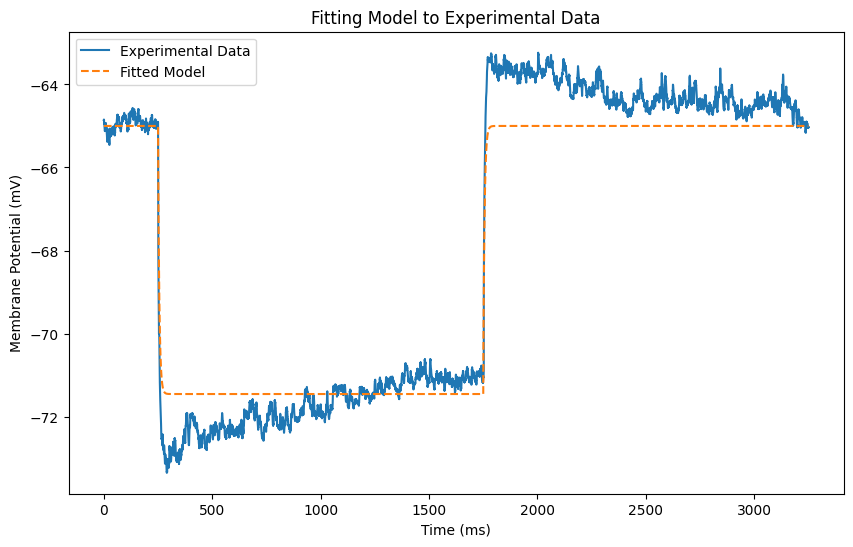

MSE: 0.4499507779156193
Ra: 59.49220378390251, cm: 0.9639527020250291, g_pas: 0.0002166621854016187


In [12]:
# Plot
Ra_opt = 59.49220378390251
cm_opt = 0.9639527020250291
g_pas = 0.0002166621854016187


delay_t =  np.round (abs (exp_t_mod[0]) * 1000, decimals = 6) # convert to ms
exp_t =  np.round ((exp_t_mod + abs (exp_t_mod[0])) * 1000, decimals = 6)
for sec in h.allsec():
  sec.insert('pas')
  sec.e_pas = -65  # Fixed passive Voltage
  sec.Ra = Ra_opt
  sec.cm = cm_opt
  sec.g_pas = g_pas

h.v_init = -65  # Initial V_m (mV)
h.dt = 0.05     # Time step for simulation (ms)

    # Create current clamp at the specified segment
stim = h.IClamp(LGMD1.FieldA[809](0.5))
stim.delay = 250      # Start of stimulus (ms)
stim.dur = 1500  # Duration of stimulus (ms)
stim.amp = -2   # Amplitude of stimulus (nA)

    # Record membrane potential and time
v_vec = h.Vector()  # V_m vector
t_vec = h.Vector()  # Time vector
recor_site = LGMD1.FieldA[809](0.5)
v_vec.record(recor_site._ref_v)
t_vec.record(h._ref_t)

    # Initialize and run the simulation
h.tstop = 3500  # Total duration in ms
h.finitialize(h.v_init)
h.continuerun(h.tstop)
v_vec = np.array (v_vec)[1:len(exp_t) + 1]
t_vec = np.array (t_vec)[1:len(exp_t) + 1]

    # Plot the fitted curve against experimental data
plt.figure(figsize=(10, 6))
plt.plot(exp_t , exp_vol_mod, label="Experimental Data")
plt.plot(t_vec, v_vec, label="Fitted Model", linestyle="--")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Fitting Model to Experimental Data")
plt.legend()
plt.show()
print (f"MSE: {np.mean((v_vec[5001:35000] - exp_vol_mod[5001:35000]) ** 2)}") # MSE for the injection period
print (f"Ra: {Ra_opt}, cm: {cm_opt}, g_pas: {g_pas}")

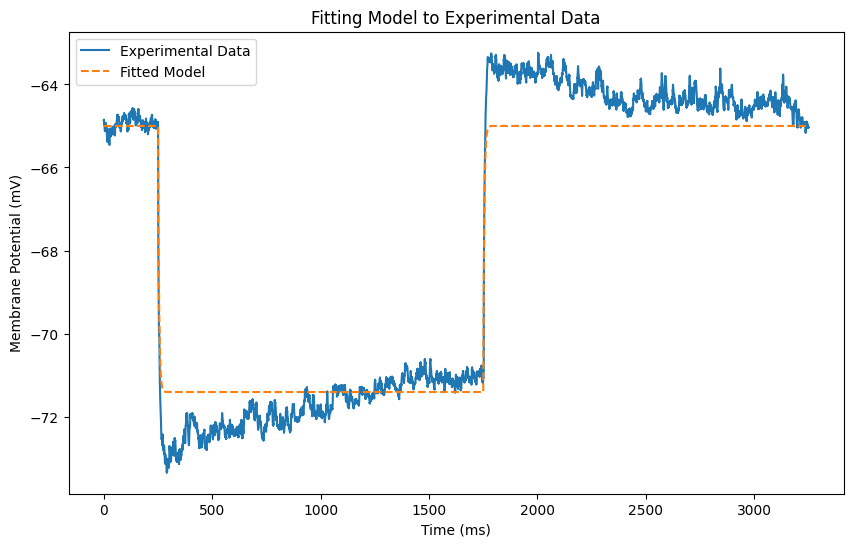

MSE: 0.4702184686837497
Ra: 58.93569860267176, cm: 0.9056348761721569, g_pas: 0.00021828504860877366


In [13]:
Ra_opt = 58.93569860267176
cm_opt = 0.9056348761721569
g_pas = 0.00021828504860877366


delay_t =  np.round (abs (exp_t_mod[0]) * 1000, decimals = 6) # convert to ms
exp_t =  np.round ((exp_t_mod + abs (exp_t_mod[0])) * 1000, decimals = 6)
for sec in h.allsec():
  sec.insert('pas')
  sec.e_pas = -65  # Fixed passive Voltage
  sec.Ra = Ra_opt
  sec.cm = cm_opt
  sec.g_pas = g_pas

h.v_init = -65  # Initial V_m (mV)
h.dt = 0.05     # Time step for simulation (ms)

    # Create current clamp at the specified segment
stim = h.IClamp(LGMD1.FieldA[809](0.5))
stim.delay = 250      # Start of stimulus (ms)
stim.dur = 1500  # Duration of stimulus (ms)
stim.amp = -2   # Amplitude of stimulus (nA)

    # Record membrane potential and time
v_vec = h.Vector()  # V_m vector
t_vec = h.Vector()  # Time vector
recor_site = LGMD1.FieldA[809](0.5)
v_vec.record(recor_site._ref_v)
t_vec.record(h._ref_t)

    # Initialize and run the simulation
h.tstop = 3500  # Total duration in ms
h.finitialize(h.v_init)
h.continuerun(h.tstop)
v_vec = np.array (v_vec)[1:len(exp_t) + 1]
t_vec = np.array (t_vec)[1:len(exp_t) + 1]

    # Plot the fitted curve against experimental data
plt.figure(figsize=(10, 6))
plt.plot(exp_t , exp_vol_mod, label="Experimental Data")
plt.plot(t_vec, v_vec, label="Fitted Model", linestyle="--")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Fitting Model to Experimental Data")
plt.legend()
plt.show()
print (f"MSE: {np.mean((v_vec[5001:35000] - exp_vol_mod[5001:35000]) ** 2)}") # MSE for the injection period
print (f"Ra: {Ra_opt}, cm: {cm_opt}, g_pas: {g_pas}")

In [ ]:
# helper function: reset
def reset_neuron():
    h('forall delete_section()')
    h.load_file("stdlib.hoc")
    h.load_file("stdrun.hoc")
    print("NEURON environment has been reset.")
reset_neuron()


In [ ]:
print (exp_vol_mod)

[-64.856 -64.849 -64.858 ... -65.035 -65.035 -65.034]
